<a href="https://colab.research.google.com/github/CristhianSeverino/customer-churn-and-contextual-chat/blob/staging/ML_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn and Contextual Chat C4**

> Este **Notebook** es una creación de: **Cristhian Calle Severino**.

---

* **GitHub**: https://github.com/CristhianSeverino
* **LinkedIn**: https://www.linkedin.com/in/cristhianandrescalleseverino/

---

Este proyecto **emula un Data Product de Machine Learning (ML) con despliegue en AWS**. Se inspira en la arquitectura **Arana**.

### **Incluye:**

* **Creación de Datos Sintéticos**: Estos datos simulan usuarios de **MallPlaza**, un nombre genérico para un supuesto ficticio, dado que grandes centros comerciales homónimos existen en ciudades de América (como Santiago de Chile y Manizales, donde resido). Esta creación se basa en un supuesto de **Ingeniería y Arquitectura de Datos** que se detalla en el **Road Map**.

---

## **Módulos del Proyecto**

El proyecto está estructurado en los siguientes **Módulos**:

> * **Módulo 1 - Creación de Datos Sintéticos**: Emula un proceso **ELT** (Extracción, Carga y Transformación) de ingesta, carga y posterior transformación de datos. El resultado es un *dataset* limpio, listo para el entrenamiento de modelos de ML.
> * **Módulo 2 - EDA (*Exploratory Data Analysis*)**: Análisis de datos exploratorio para la identificación de *insights* previos al ML. Incluye la búsqueda de características de enriquecimiento y el desarrollo de **Feature Engineering**.
> * **Módulo 3 - Entrenamiento y Evaluación del Algoritmo**: Desarrollo del modelo, métricas de ajuste, evaluación de precisión y **Fine Tuning**.
> * **Módulo 4 - Despliegue en AWS**: Implementación y prueba del despliegue en la nube.

---

## **Prerrequisitos y Recomendaciones**

**Nota**: Para este proyecto se emplea **AWS como *cloud platform***.

Es **indispensable** poseer conocimientos en las siguientes tecnologías para comprender a cabalidad los aspectos técnicos:

* **Lenguajes y Bases de Datos**: Python, SQL.
* **Big Data y ML**: PySpark, Keras, Scikit-learn, PyTorch.
* **Cloud y Herramientas MLOps**: AWS.
* **IA y Desarrollo de Aplicaciones**: LangChain, RAG, Streamlit, Gradio.

Para una comprensión general del proyecto, **recomiendo encarecidamente la lectura del Road Map** y una revisión general de la documentación del código. 🦾

> ¡Que disfrutes explorando este proyecto! Exitosa semana. 🐱‍🏍

# **Modulo 3** ML por las caracteristcias del proyecto y el data set considero que la mejor formade optimizar recursos tato de entrenamiento como de despiegue es hacer una aalisis AB sbre modelos de Machine learning dejando a un lado DL. para implementaciones futuras

# **Step 1 - Instalar e Importar Librerias 📚**

In [30]:
!pip install boto3

In [31]:
!pip install awscli
print("="*45+"   Librerias AWS Instaldas   "+"="*45)
# Si arroja Error Vuelve a ejecutar ===> La solucion mas simple es la mejor;)

=============================================   Librerias AWS Instaldas   =============================================


In [32]:
import pyarrow.parquet as pq
import pyarrow as pa
from datetime import datetime, timedelta
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt



# Ml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import joblib
print("="*150)
print("="*45+"   ML Librerias Importadas  "+"="*45)
# Colab and AWS
import warnings
import boto3
from google.colab import userdata
from google.colab import files
import botocore.exceptions
warnings.filterwarnings('ignore')
print("="*150)
print("="*45+"   AWS Librerias Importadas  "+"="*45)
print("="*150)


=============================================   ML Librerias Importadas  =============================================
=============================================   AWS Librerias Importadas  =============================================


# **Step 2 - Configurar Credenciales AWS 🎫**

In [33]:
aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID')
aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')

region_name=userdata.get('AWS_REGION')
bucket_name=userdata.get('s3_mallflow')
s3 = s3 = boto3.client(
    's3',
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY')
)
git_path= userdata.get('GIT_PATH')
print("="*150)
print(" "*50+"Paths Ok")
print("="*150)

                                                  Paths Ok


In [34]:
aws_dir = '/root/.aws'
os.makedirs(aws_dir, exist_ok=True)
with open(os.path.join(aws_dir, 'credentials'), 'w') as f:
    f.write(f'[default]\n')
    f.write(f'aws_access_key_id = {aws_access_key_id}\n')
    f.write(f'aws_secret_access_key = {aws_secret_access_key}\n')
# Write 'config'
with open(os.path.join(aws_dir, 'config'), 'w') as f:
    f.write(f'[default]\n')
    f.write(f'region = {region_name}\n')
print("="*100)
print(" "*25+"Archivos de cofiguracion de AWS creados Exitosamente ☕")
print("="*100)

                         Archivos de cofiguracion de AWS creados Exitosamente ☕


# **Step 3 - Carga del Dataset desde el Bucket de S3**💽

> En esta seccion se carga el data set en el DataFrame df



In [35]:
def download_from_s3(bucket_name, s3_file_path, local_file_path):
    try:
        #Configuurar cliente S3
        s3_client = boto3.client('s3')

        #crear el directorio local
        local_dir = os.path.dirname(local_file_path)
        if local_dir:
            os.makedirs(local_dir, exist_ok=True)

        #Descargar el Archivo desde S3
        s3_client.download_file(bucket_name, s3_file_path, local_file_path)
        print(f"Archivo Descargado Con ¡Exito!: {local_file_path}")
        return True

    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code']== "404":
            print(f"El archivo {s3_file_path} no existe en el buket {bucket_name}. VERIFICA LOS NOMBRES")
        else:
            print(f"Error al descargar el archivo desde S3: {str(e)}")
            return False

    except Exception as e:
        print(f"Error inesperado: {str(e)}")
        return False

In [36]:
#=========================   Inicializacion de las funciones de optencion de los datasets   ==========================

if __name__ == "__main__":
  #Cofigurar Credeciales
    bucket_name = "mall-flow"


    files_download = [
        ("warehouse-ml/churn_abril_mallplaza/churn_abril_mallplaza.csv", "content/churn_abril_mallplaza.csv"),
    ]

    for s3_file_path, local_file_path in files_download:
        print(f"Descargando {s3_file_path} a {local_file_path}...")
        success = download_from_s3(bucket_name, s3_file_path, local_file_path)
        if not success:
            print(f"No se Pudo descargar {s3_file_path}")

Descargando warehouse-ml/churn_abril_mallplaza/churn_abril_mallplaza.csv a content/churn_abril_mallplaza.csv...
Archivo Descargado Con ¡Exito!: content/churn_abril_mallplaza.csv


In [37]:
df=pd.read_csv(local_file_path)
df.columns

Index(['customerId', 'name', 'age', 'visits', 'avg_session_time', 'complaints',
       'total_session_time', 'complaints_per_visit', 'log_visits',
       'high_complaints', 'engagement_score', 'gender_age_ifemale',
       'gender_age_imale', 'gender_age_iother', 'last_visit_date',
       'recency_days', 'tenure_months', 'data_usage_total', 'gender_Female',
       'gender_Male', 'gender_Other', 'location_Arcades', 'location_Cinemas',
       'location_Electronica', 'location_Gimnasios', 'location_mall_central',
       'location_mall_comidas_1', 'location_mall_comidas_2',
       'location_mega_tienda', 'device_type_Laptop', 'device_type_Smartphone',
       'device_type_Tablet', 'age_group_Young', 'age_group_Adult',
       'age_group_Senior', 'churn_No', 'churn_Yes'],
      dtype='object')

# **Preprocesing** 🚨


> Scalar datos y Seleccionar Pipelie de 3 modelos



In [38]:
X = df.drop(['customerId', 'name', 'last_visit_date', 'churn_No', 'churn_Yes'], axis=1)
y = df['churn_Yes']

# Identify numerical columns for scaling
numeric_cols = ['age', 'visits', 'avg_session_time', 'complaints',
       'total_session_time', 'complaints_per_visit', 'log_visits',
       'high_complaints', 'engagement_score', 'gender_age_ifemale',
       'gender_age_imale', 'gender_age_iother', 'recency_days', 'tenure_months', 'data_usage_total', 'gender_Female',
       'gender_Male', 'gender_Other', 'location_Arcades', 'location_Cinemas',
       'location_Electronica', 'location_Gimnasios', 'location_mall_central',
       'location_mall_comidas_1', 'location_mall_comidas_2',
       'location_mega_tienda', 'device_type_Laptop', 'device_type_Smartphone',
       'device_type_Tablet', 'age_group_Young', 'age_group_Adult',
       'age_group_Senior']

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale numerical features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Handle class imbalance with SMOTE (after scaling to avoid distortion)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Train shape after SMOTE: {X_train_smote.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Churn distribution in train after SMOTE: {np.mean(y_train_smote):.2f}")

Train shape after SMOTE: (71830, 32), Val shape: (15000, 32), Test shape: (15000, 32)
Churn distribution in train after SMOTE: 0.50


## **Defiir 3 - Modelos Para pruebas A/B 🥇🥈**

In [39]:
# Step 3: Define 3 Models with Pipelines (includes scaling for consistency)
models = {
    'LogisticRegression': {
        'pipeline': Pipeline([
            ('model', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__solver': ['liblinear', 'lbfgs'],
            'model__class_weight': ['balanced', None]
        }
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
        ]),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 20],
            'model__min_samples_split': [2, 5],
            'model__class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'pipeline': Pipeline([
            ('model', XGBClassifier(random_state=42, eval_metric='auc', n_jobs=-1))
        ]),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1],
            'model__scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
        }
    }
}

# **Step 4 - Train, Tune, and Evaluate Models 🦾**

In [40]:
results = {}
feature_importances = {}
roc_curves = {}

for name, config in models.items():
    start_time = time.time()
    print(f"\nTraining and tuning {name}...")

    # Hyperparameter tuning with GridSearchCV
    grid = GridSearchCV(config['pipeline'], config['params'], cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid.fit(X_train_smote, y_train_smote)  # Use SMOTE data for training

    best_model = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best CV ROC-AUC: {grid.best_score_:.4f}")

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    results[name] = {
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Training Time (s)': time.time() - start_time
    }

    # Feature importance
    model = best_model.named_steps['model']
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    elif name == 'LogisticRegression':
        feature_importances[name] = pd.Series(model.coef_[0], index=X.columns).abs().sort_values(ascending=False)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr, auc(fpr, tpr))

    # Save model
    joblib.dump(best_model, f'{name}_churn_model.pkl')


Training and tuning LogisticRegression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for LogisticRegression: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'liblinear'}
Best CV ROC-AUC: 0.8117

Training and tuning RandomForest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for RandomForest: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.8100

Training and tuning XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__scale_pos_weight': 1}
Best CV ROC-AUC: 0.8098


# **Step 5 - Display Results 🏹**

In [41]:
results_df = pd.DataFrame(results).T
print("="*100)
print(" "*25+"Model Comparison (A/B Testing Results):")
print("="*100)
print(results_df)
print("="*100)



                         Model Comparison (A/B Testing Results):
                     ROC-AUC  Precision    Recall  F1-Score  Training Time (s)
LogisticRegression  0.816255   0.727371  0.740416  0.733835          34.660328
RandomForest        0.814518   0.729147  0.745619  0.737291        1498.967859
XGBoost             0.814706   0.725740  0.742333  0.733942         118.441373


# **Step 6 - Visualizations 📊**

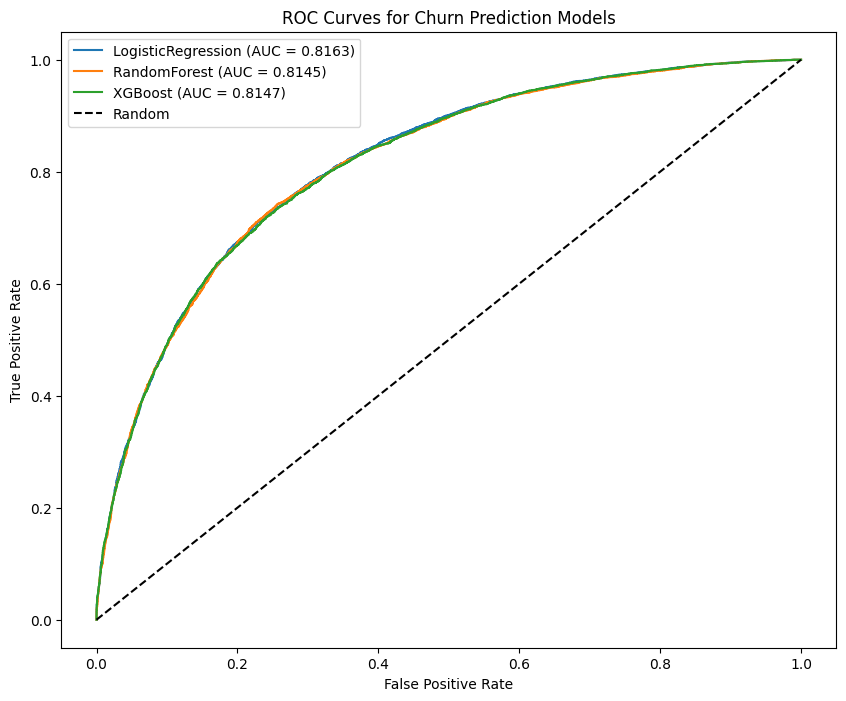


Top 10 Feature Importances for LogisticRegression:


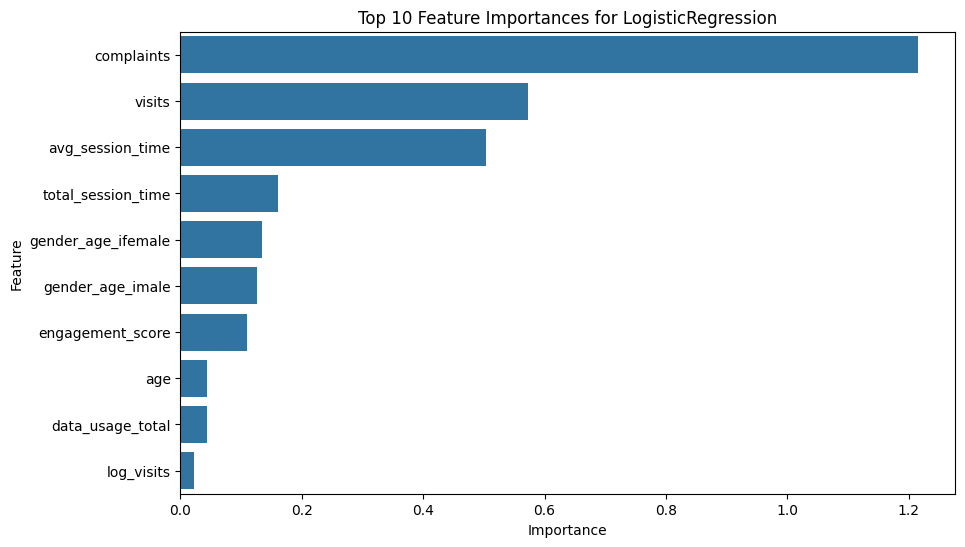


Top 10 Feature Importances for RandomForest:


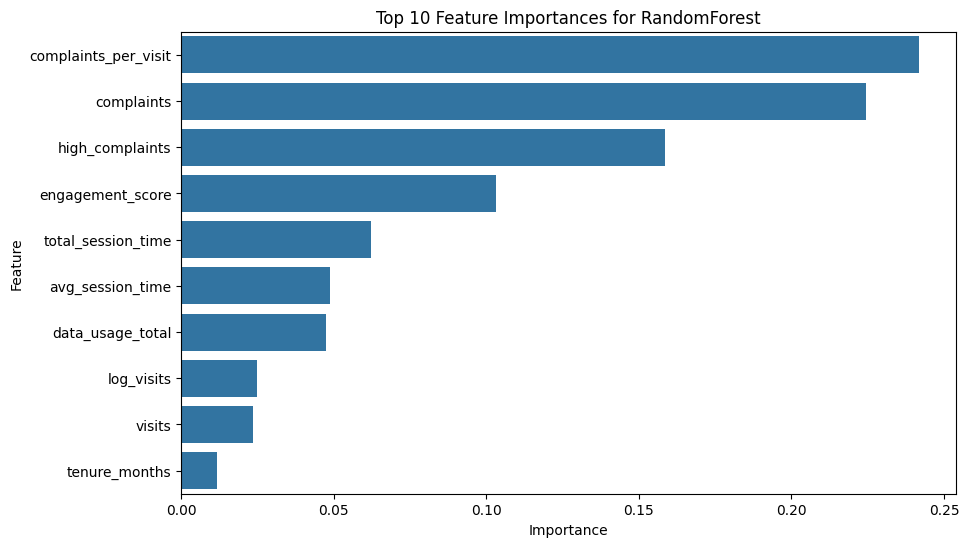


Top 10 Feature Importances for XGBoost:


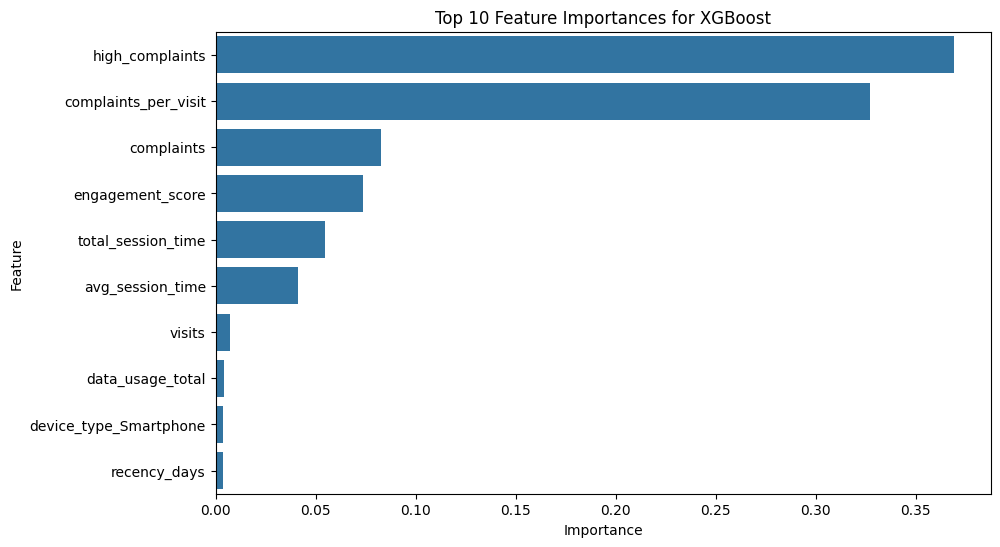

In [42]:
# ROC Curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn Prediction Models')
plt.legend()
plt.savefig('roc_curves.png')
plt.show()

# Feature Importance (Top 10)
for name, imp in feature_importances.items():
    print(f"\nTop 10 Feature Importances for {name}:")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=imp.head(10).values, y=imp.head(10).index)
    plt.title(f'Top 10 Feature Importances for {name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(f'{name}_feature_importance.png')
    plt.show()



# **Step 7 - Cross Validation on Best Model 🦾🤖🧭**

In [43]:
best_model_name = results_df['ROC-AUC'].idxmax()
print(f"\nBest model: {best_model_name} with ROC-AUC {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")

best_model = joblib.load(f'{best_model_name}_churn_model.pkl')
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"Cross-Validation ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Optional: Save scaler for production
joblib.dump(scaler, 'scaler_churn.pkl')


Best model: LogisticRegression with ROC-AUC 0.8163
Cross-Validation ROC-AUC: 0.8132 ± 0.0044


['scaler_churn.pkl']